In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from IPython.display import display

from tqdm import tqdm


import math

In [2]:
df_train = pd.read_excel("./Data/Lab3_data.xls", sheet_name = "2004--2005 Data")
df_train.head()

,y,x1,x2
0,1,71,140
1,1,74,185
2,1,70,145
3,1,67,145
4,1,72,170


In [3]:
df_test = pd.read_excel("./Data/Lab3_data.xls", sheet_name = "2004--2007 Data")
df_test.head()

,y,x1,x2
0,1,71.0,140
1,1,74.0,185
2,1,70.0,145
3,1,67.0,145
4,1,72.0,170


In [4]:
class LogisticRegressionClass:
    def __init__(self, data, target, learning_rate = 0.00005, epsilon = 1e-8, 
                 max_iterations= 1000, reg_type = None, reg_lambda = 0, 
                 fit_intercept = True, print_log = False, remove_index = []) -> None:
         
        """
        @data: pandas dataframe or np.array, Passed data,

        @does: Apply logistic Reg,
        @return: weights, confusion matrix, and related graphs,
        """
        self.fit_intercept = fit_intercept
        self.remove_index = remove_index
        
        self.X = np.insert(data.to_numpy(),0,1,axis=1) if self.fit_intercept == True else data.to_numpy() # Intercept term based on user preference
        self.y = target.to_numpy()
        
        # Regularization
        self.reg_type = reg_type
        self.reg_lambda = 0 if self.reg_type == None else reg_lambda
        
        # gradient descent parameters
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iterations = max_iterations
        self.weight = None
        
        self.print_log = print_log
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def multiply(self, X):
        return np.matmul(X, self.weight)
    
    def predict(self, X, cutoff = 0.5): # prediction based on cutoff value
        sol = self.sigmoid(np.matmul(X, self.weight))
        return (sol > cutoff).astype(int)

    def loss_functions(self, X, y):
        y_hat = self.multiply(X)
        p = self.sigmoid(y_hat)
        #return -1 - np.dot(y, y_hat) + (self.sigmoid(y_hat)).sum()
        return -(np.matmul(y, np.log(p)) + np.matmul(1-y, np.log(1-p)))/len(y)


    def derivative_loss_functions(self, X, y):
        y_hat = self.multiply(X)
        return np.matmul(X.T, (self.sigmoid(y_hat) - y))
        
        
    def reg_functions(self):
        if self.reg_type == "L2":
            return ((self.weight) ** 2).sum()
        
        if self.reg_type == "L1":
            return (abs(self.weight)).sum()
        else:
            return 0

    def derivative_reg_functions(self):

        if self.reg_type == "L2":
            return 2* self.weight
        
        if self.reg_type == "L1":
            return np.sign(self.weight)
        
        else:
            return 0
        
    def gradient_descent(self, X, y):
        costs = []
        iterations = []
        previous_cost = math.inf
        for iter in tqdm(range(1, self.max_iterations)):
            
            step = self.learning_rate * (self.derivative_loss_functions(X, y) + self.reg_lambda * self.derivative_reg_functions())
            
            self.weight = self.weight - step
            
            current_cost = self.loss_functions(X, y) + self.reg_lambda * self.reg_functions()
            #print(current_cost)
            costs.append(current_cost)
            iterations.append(iter)
            
            
            if self.print_log:
                print("Step : " + str(iter) + ": ","\n")
                print("\t" + "change ",step, "\n")
                print("current_weights: ", self.weight)
                print("current_cost: ", current_cost)
                print("current_cost_change: ", abs(current_cost - previous_cost), "\n")
            
            if abs(current_cost - previous_cost) < self.epsilon:
                print("Done")
                break
            previous_cost = current_cost
        self.fig_plot(x_data = iterations, y_data = costs)
    
    def evaluation_metrics(self, X = None, y = None, mode = "train"):
        
        if mode == "train":
            print("Training metrics")
            y_pred = self.predict(self.X)
            self.confusion_matrix(self.y, y_pred)
        
        elif (mode == 'test') and (X is not None) and (y is not None):
            print("Testing metrics")
            
            X = np.insert(X.to_numpy(),0,1,axis=1) if self.fit_intercept == True else X.to_numpy()
            y = y.to_numpy()
        
            y_pred = self.predict(X)
            self.confusion_matrix(y, y_pred)
        

    def confusion_matrix(self, y, y_pred):
        
        a1_p1 = np.sum((y & y_pred))
        a1_p0 = y.sum() - a1_p1

        a0_p1 = y_pred.sum() - a1_p1
        a0_p0 = len(y) - y.sum() - a0_p1

        matrix = np.array([[a0_p0, a0_p1], [a1_p0, a1_p1]])

        plt.figure(figsize=(10,6))
        sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        
        ## Metrics
        Accuracy = (a1_p1 + a0_p0)/ len(y)
        Error_rate = 1 - Accuracy
        
        Sensitivity = a1_p1/y.sum()
        False_Negative_Rate = 1 - Sensitivity
        
        Specificity = a0_p0/(len(y) - y.sum())
        
        F1_score = 2 * Sensitivity * Specificity/(Sensitivity + Specificity)
        
        Precision = a1_p1/y_pred.sum()
        
        metrics_df = pd.DataFrame({ "Metrics": ["Accuracy", "Error rate", "Sensitivity/Recall/True Positive Rate", 
                                                "False Negative Rate", "Specificity/True Negative Rate", "F1 score",
                                                "Positive Predictive Value (PPV) or Precision"
                                               ],
                                   "Values": [Accuracy, Error_rate, Sensitivity, False_Negative_Rate,
                                             Specificity, F1_score, Precision
                                             ]
        
        })
        metrics_df.set_index("Metrics", inplace = True)
        display(metrics_df)
        
    def fig_plot(self, x_data, y_data):
        # Error plot
        plt.figure(figsize=(10,6))
        plt.title("Error Graph")
        plt.xlabel("Iterations")
        plt.ylabel("Cost")
        sns.lineplot(x= x_data, y= y_data)
    
    def plot(self):
        # 3D plot
        
        plt.figure(figsize=(14,12))
        ax = plt.axes(projection='3d')

        # Data for three-dimensional scattered points and added intercept customization
        if self.fit_intercept:
            _add = 1
        else:
            _add = 0
        ax.scatter3D(self.X[:, 0 + _add], self.X[:, 1 + _add],
                     self.sigmoid(np.matmul(self.X, self.weight)),
                     c = self.y, cmap='viridis', s=100);

        #ax.set_xlim3d(55, 80)
        #ax.set_ylim3d(80, 240)
        plt.xlabel('$x_1$ feature', fontsize=15)
        plt.ylabel('$x_2$ feature', fontsize=15, )
        ax.set_zlabel('$P(Y = 1|x_1, x_2)$', fontsize=15, rotation = 0)
    
    def scatterPlt(self):
        
        if self.fit_intercept:
            _add = 1
        else:
            _add = 0
        
        x_min, x_max = min(self.X[:, 0 + _add]) - 1, max(self.X[:, 0 + _add]) + 1
        y_min, y_max = min(self.X[:, 1 + _add]) - 1, max(self.X[:, 1 + _add]) + 1

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                             np.linspace(y_min, y_max, 1000))
        gen_data = np.c_[xx.ravel(), yy.ravel()]
        
        gen_data = np.insert(gen_data,0,1,axis=1) if self.fit_intercept == True else gen_data
        
        probs = self.sigmoid(np.matmul(gen_data, self.weight[:])).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))


        ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)
        
        ax.scatter(self.X[:, 0 + _add], self.X[:, 1 + _add], 
                   c=self.y, s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        plt.xlabel('x1 feature')
        plt.ylabel('x2 feature')
    
    def plot3D(self):
        
        if self.fit_intercept:
            _add = 1
        else:
            _add = 0
        
        x_min, x_max = min(self.X[:, 0 + _add]) - 1, max(self.X[:, 0 + _add]) + 1
        y_min, y_max = min(self.X[:, 1 + _add]) - 1, max(self.X[:, 1 + _add]) + 1

        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                             np.linspace(y_min, y_max, 1000))
        gen_data = np.c_[xx.ravel(), yy.ravel()]
        
        gen_data = np.insert(gen_data,0,1,axis=1) if self.fit_intercept == True else gen_data
        
        probs = np.matmul(gen_data, self.weight[:]).reshape(xx.shape)

        f, ax = plt.subplots(figsize=(14,12))

        ax = plt.axes(projection='3d')
        ax.contour3D(xx, yy, probs, 50, cmap='binary')

        ax.scatter(self.X[:, 0 + _add], self.X[:, 1 + _add], 
                   c=self.y, s=50,
                   cmap="RdBu", vmin=-.2, vmax=1.2,
                   edgecolor="white", linewidth=1)

        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('probs')
        ax.set_title('3D contour')
        plt.show()
    

    def fit(self):
        
        ## Remove Index 
        
        if len(self.remove_index) != 0:
            self.X = np.delete(self.X, np.array(self.remove_index)-1, axis=0)
            self.y = np.delete(self.y, np.array(self.remove_index)-1, axis=0)
        
        #self.weight = np.random.randn(self.X.shape[1])
        self.weight = np.zeros(self.X.shape[1])
        self.gradient_descent(self.X, self.y)
        print("Gradient descent used")
        print(self.weight, "\n")
        
        self.evaluation_metrics(mode = "train")

In [5]:
X = df_train.drop(["y"], axis = 1)
mean = X.mean()
std = X.std()
X = (X - mean)/std
y = df_train["y"]

X.shape, y.shape

((46, 2), (46,))

In [6]:
X_test = df_test.drop(["y"], axis = 1)
X_test = (X_test - mean)/std
y_test = df_test["y"]

X_test.shape, y_test.shape

((95, 2), (95,))

 12%|█▏        | 11953/99999 [00:00<00:01, 48076.23it/s]


Done
Gradient descent used
[0.93511336 0.64657301 0.83636506] 

Training metrics


,Values
Metrics,
Accuracy,0.978261
Error rate,0.021739
Sensitivity/Recall/True Positive Rate,1.000000
False Negative Rate,0.000000
Specificity/True Negative Rate,0.900000
F1 score,0.947368
Positive Predictive Value (PPV) or Precision,0.972973


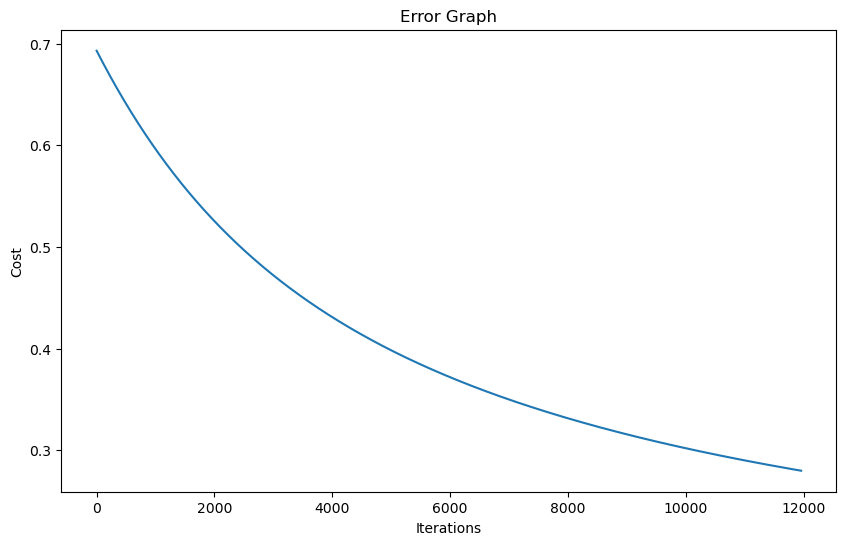

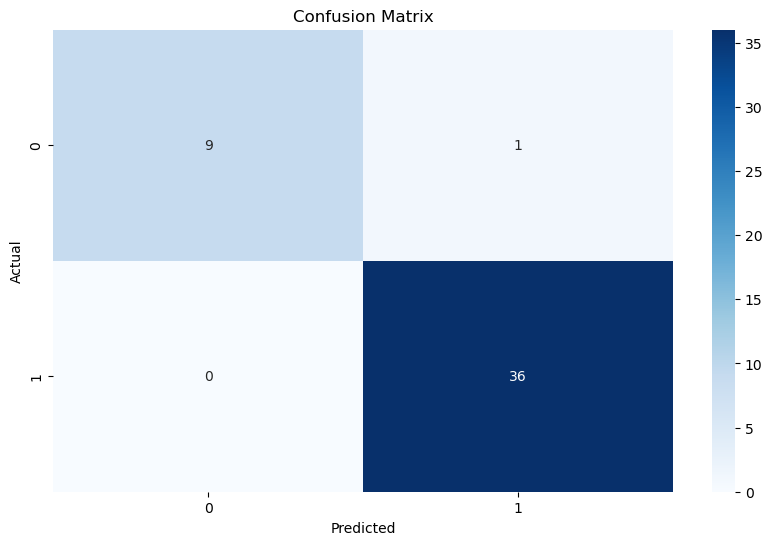

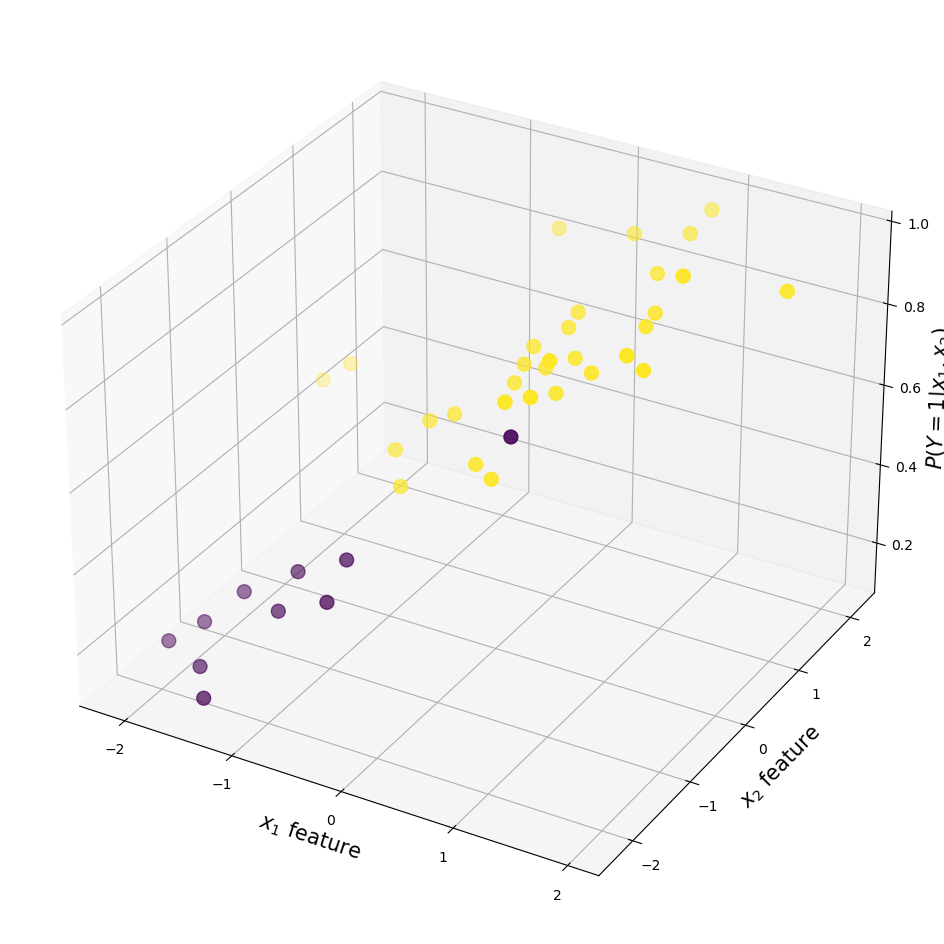

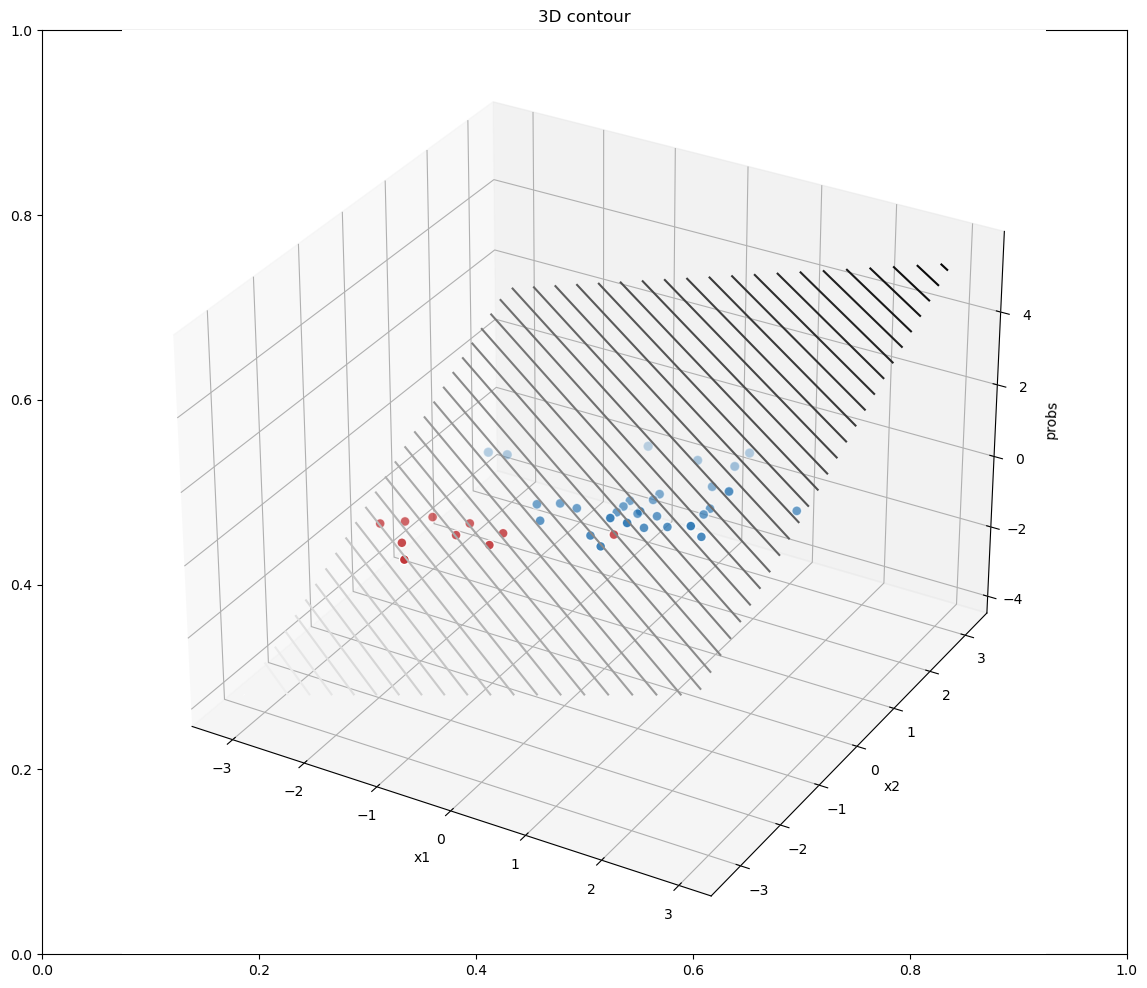

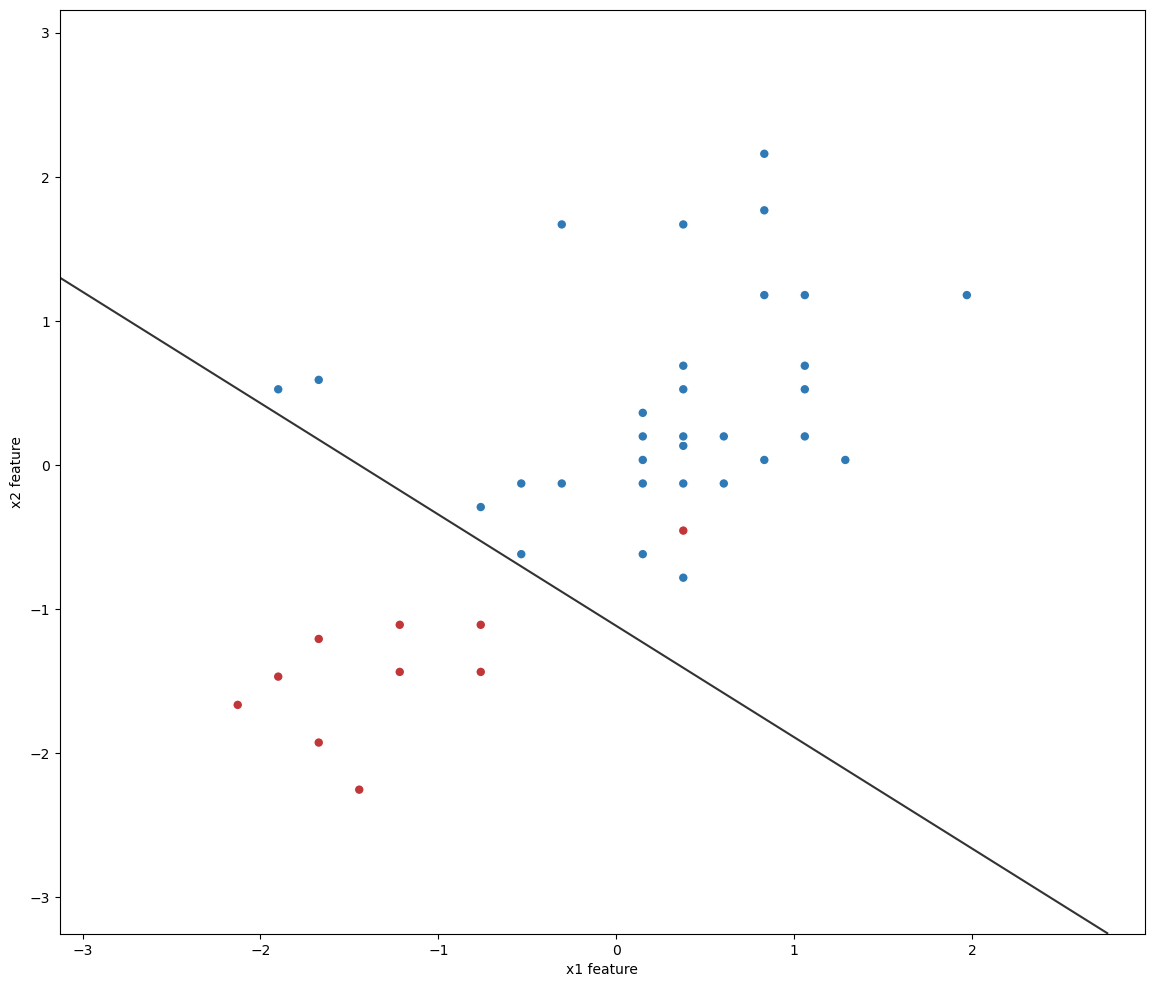

In [7]:
solver = LogisticRegressionClass(data= X, target= y, learning_rate = 1e-5, 
                                 epsilon = 1e-5, max_iterations= 100000)
solver.fit()
solver.plot()
solver.plot3D()
solver.scatterPlt()

Testing metrics


,Values
Metrics,
Accuracy,0.894737
Error rate,0.105263
Sensitivity/Recall/True Positive Rate,0.918919
False Negative Rate,0.081081
Specificity/True Negative Rate,0.809524
F1 score,0.860759
Positive Predictive Value (PPV) or Precision,0.944444


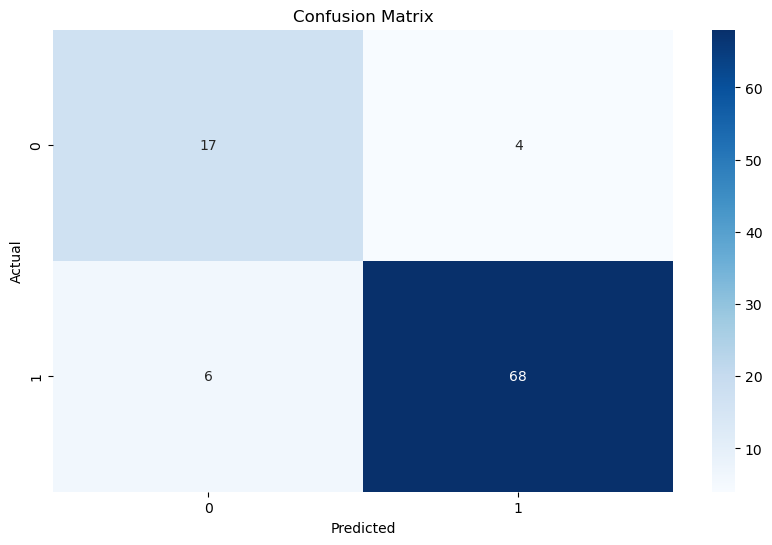

In [8]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = "test")

 13%|█▎        | 12816/99999 [00:00<00:01, 45248.60it/s]


Done
Gradient descent used
[0.99587239 0.67279275 0.87285572] 

Training metrics


,Values
Metrics,
Accuracy,1.0
Error rate,0.0
Sensitivity/Recall/True Positive Rate,1.0
False Negative Rate,0.0
Specificity/True Negative Rate,1.0
F1 score,1.0
Positive Predictive Value (PPV) or Precision,1.0


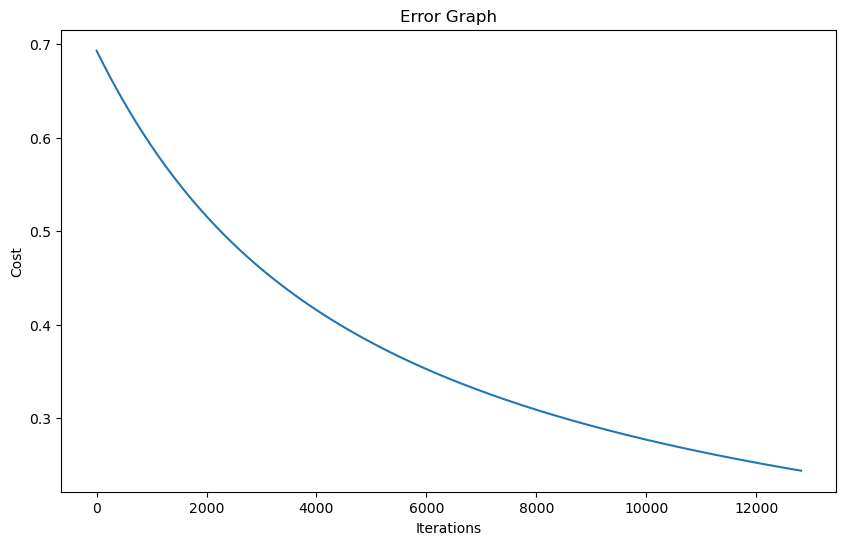

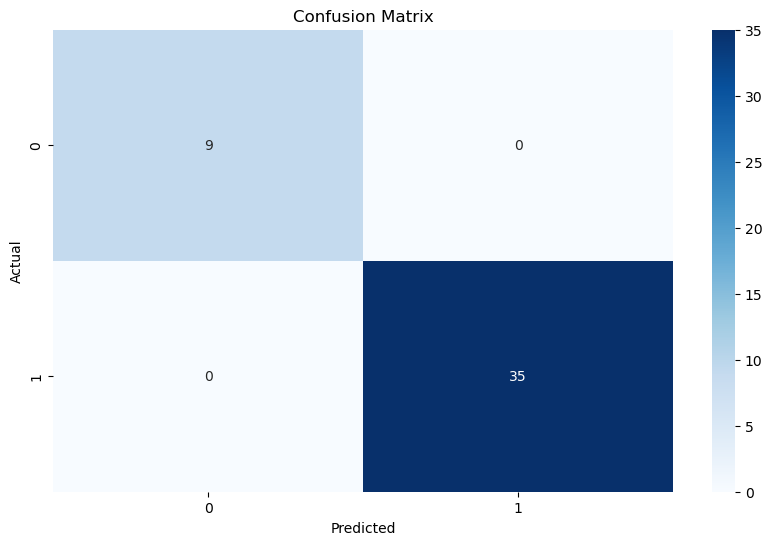

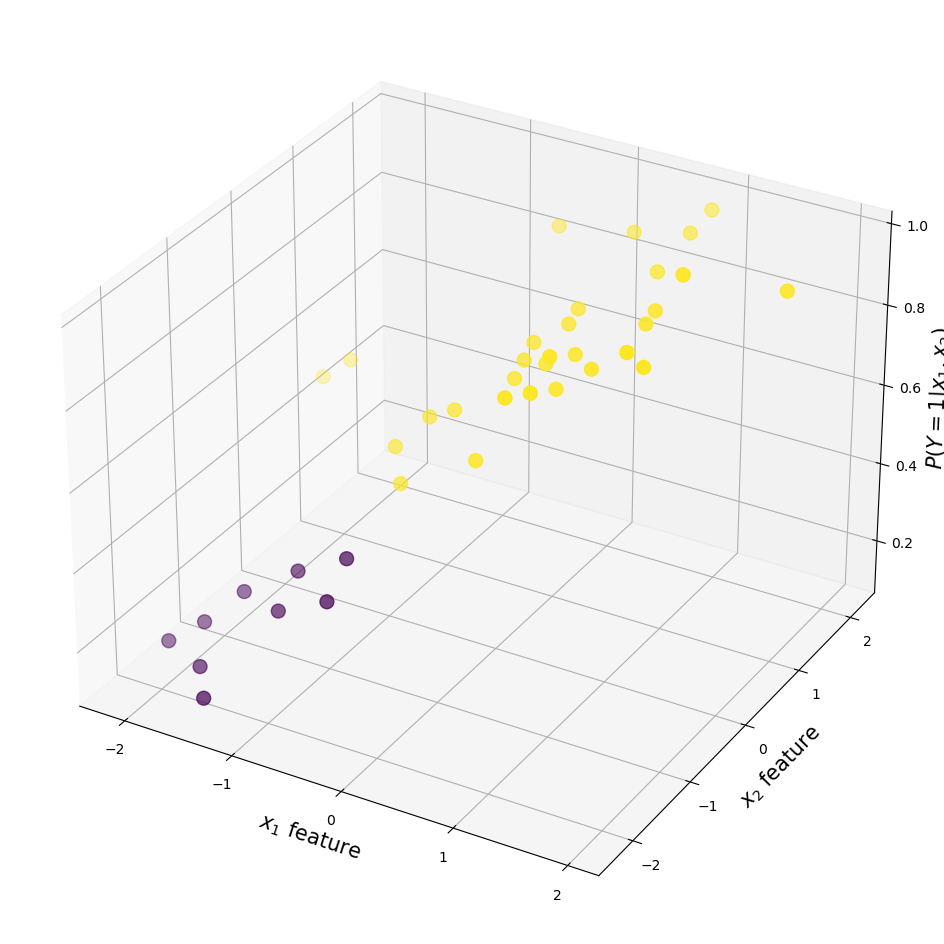

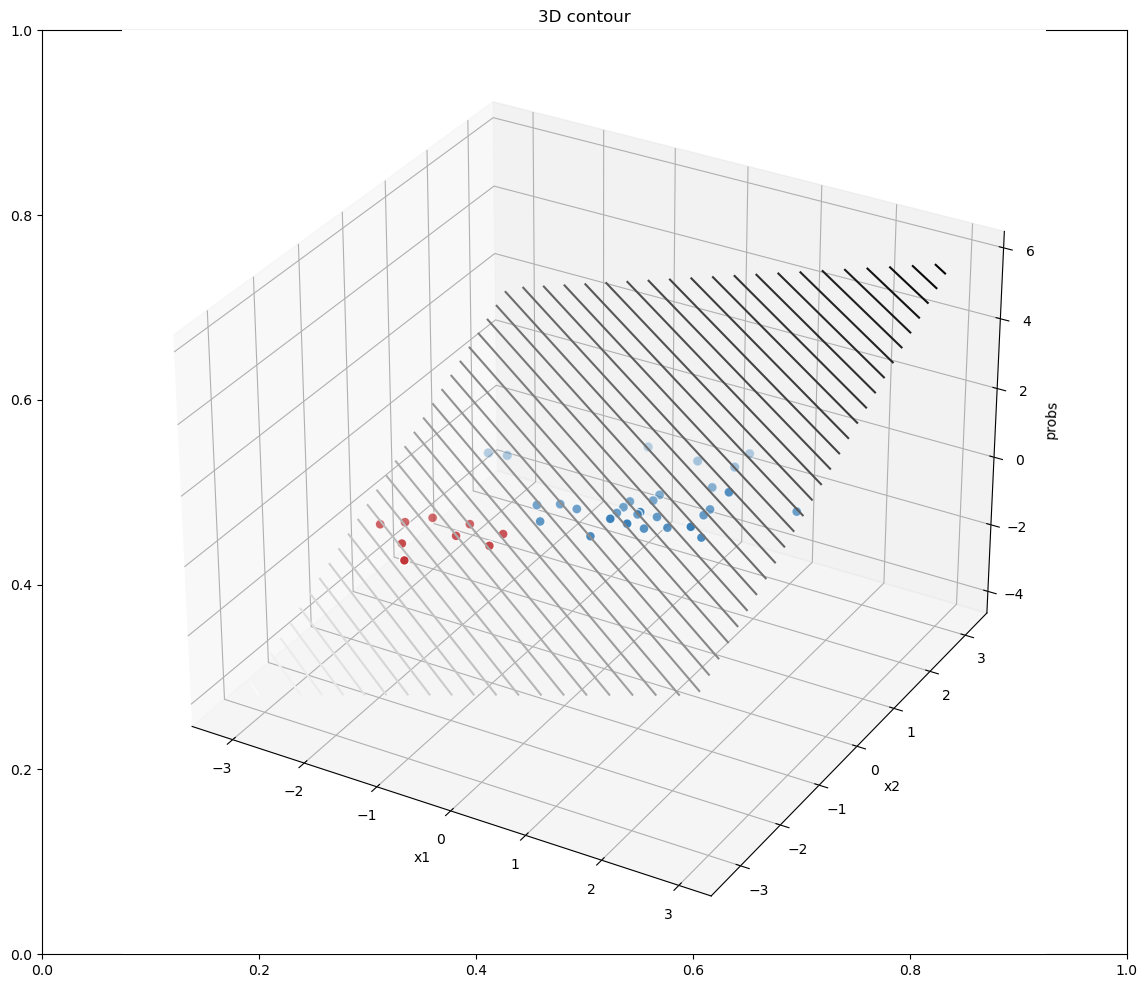

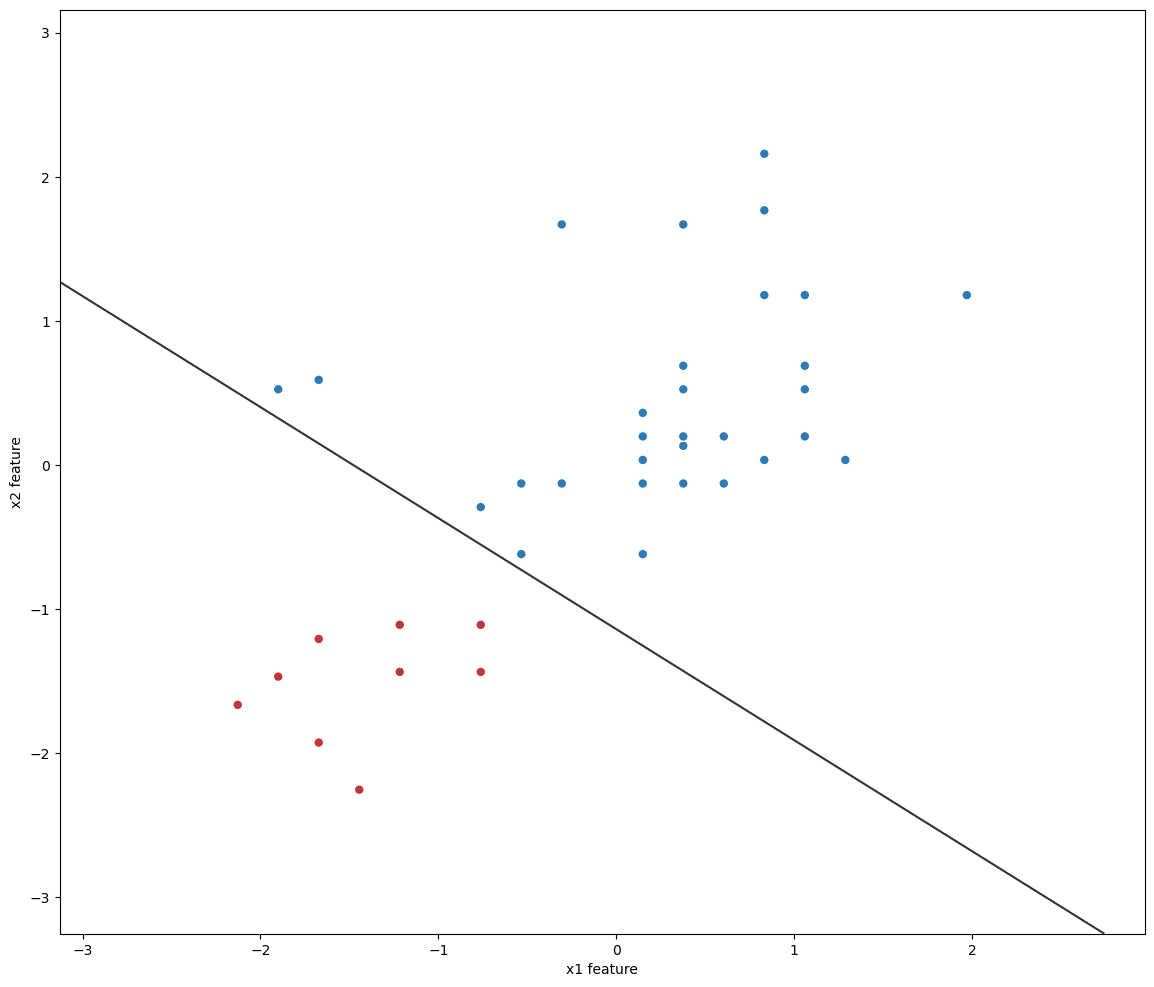

In [9]:
solver = LogisticRegressionClass(data= X, target= y, learning_rate = 1e-5, 
                                 epsilon = 1e-5, max_iterations= 100000, remove_index = [1, 39])
solver.fit()
solver.plot()
solver.plot3D()
solver.scatterPlt()

Testing metrics


,Values
Metrics,
Accuracy,0.894737
Error rate,0.105263
Sensitivity/Recall/True Positive Rate,0.918919
False Negative Rate,0.081081
Specificity/True Negative Rate,0.809524
F1 score,0.860759
Positive Predictive Value (PPV) or Precision,0.944444


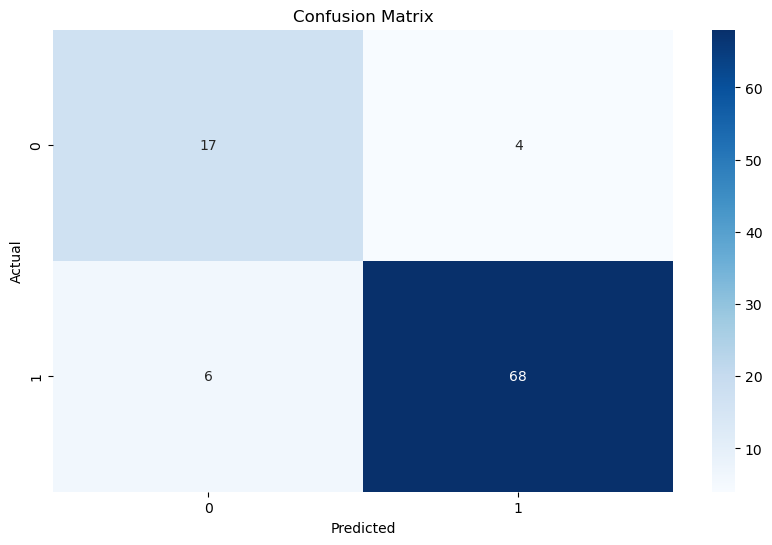

In [10]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = "test")

## Intrepretations

- As we removed the point 1 and 39 from our training metrics and graph plotted we got an ideal result which is because after the removal the data became linearly seperable without any overplapping between classes which can be observed from the above graphs

### No intercept Term

  7%|▋         | 6811/99999 [00:00<00:04, 21857.48it/s]

Done
Gradient descent used
[0.48673566 0.59090296] 

Training metrics


,Values
Metrics,
Accuracy,0.782609
Error rate,0.217391
Sensitivity/Recall/True Positive Rate,0.722222
False Negative Rate,0.277778
Specificity/True Negative Rate,1.000000
F1 score,0.838710
Positive Predictive Value (PPV) or Precision,1.000000


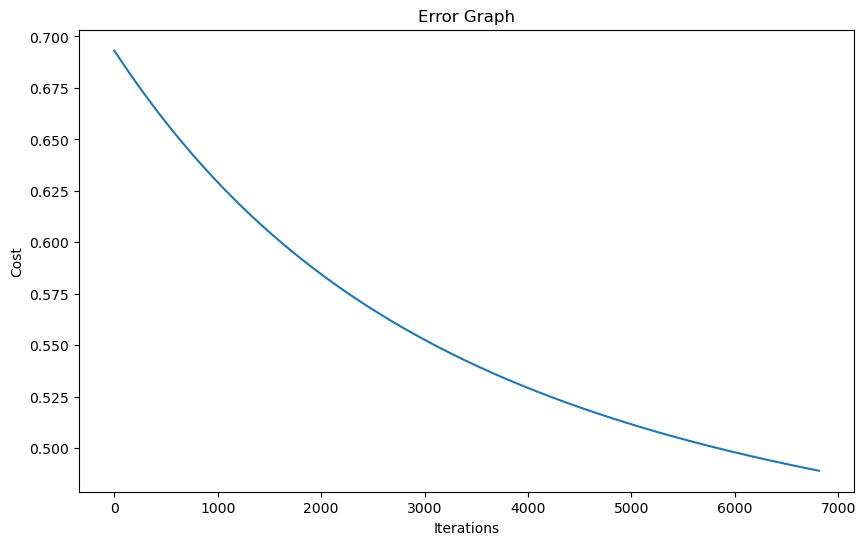

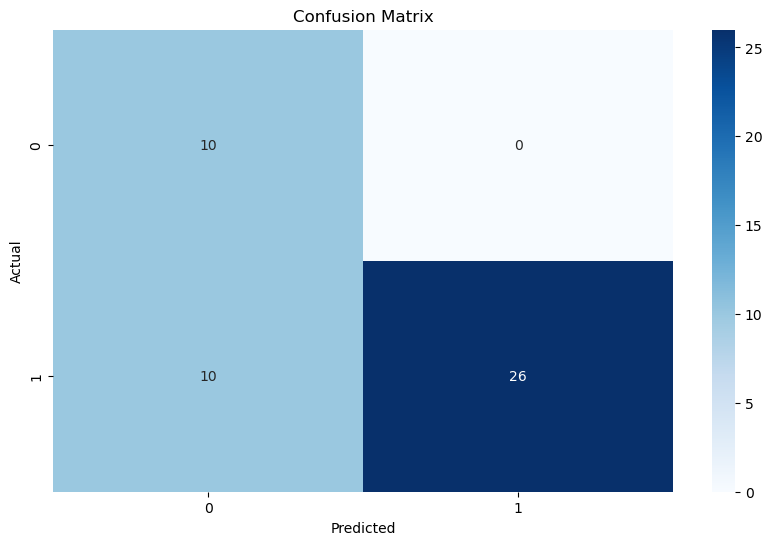

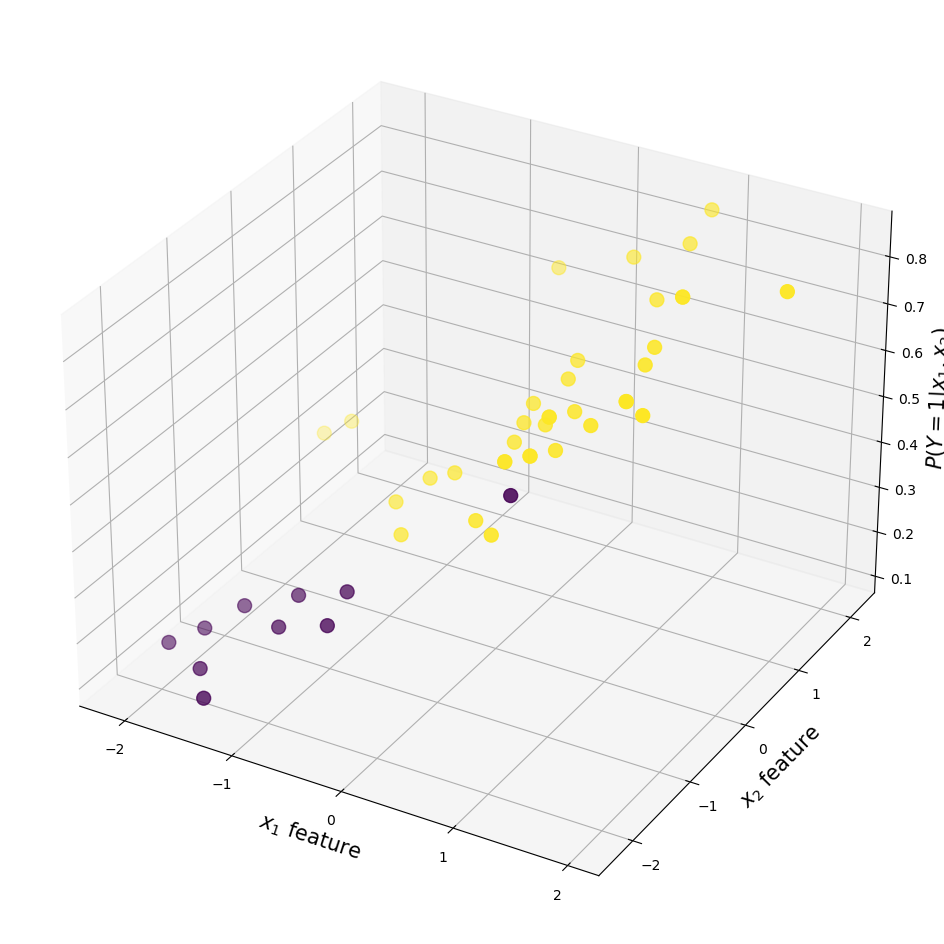

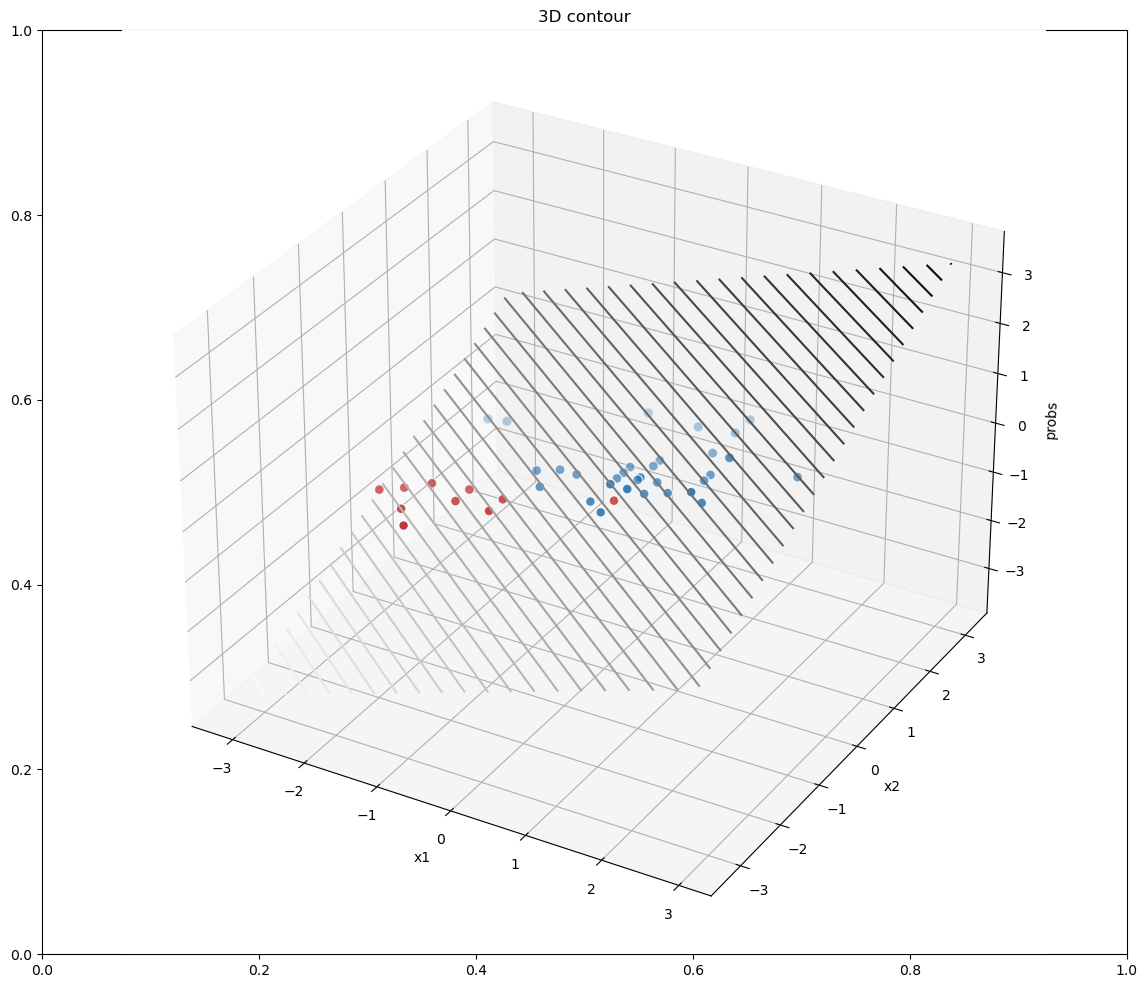

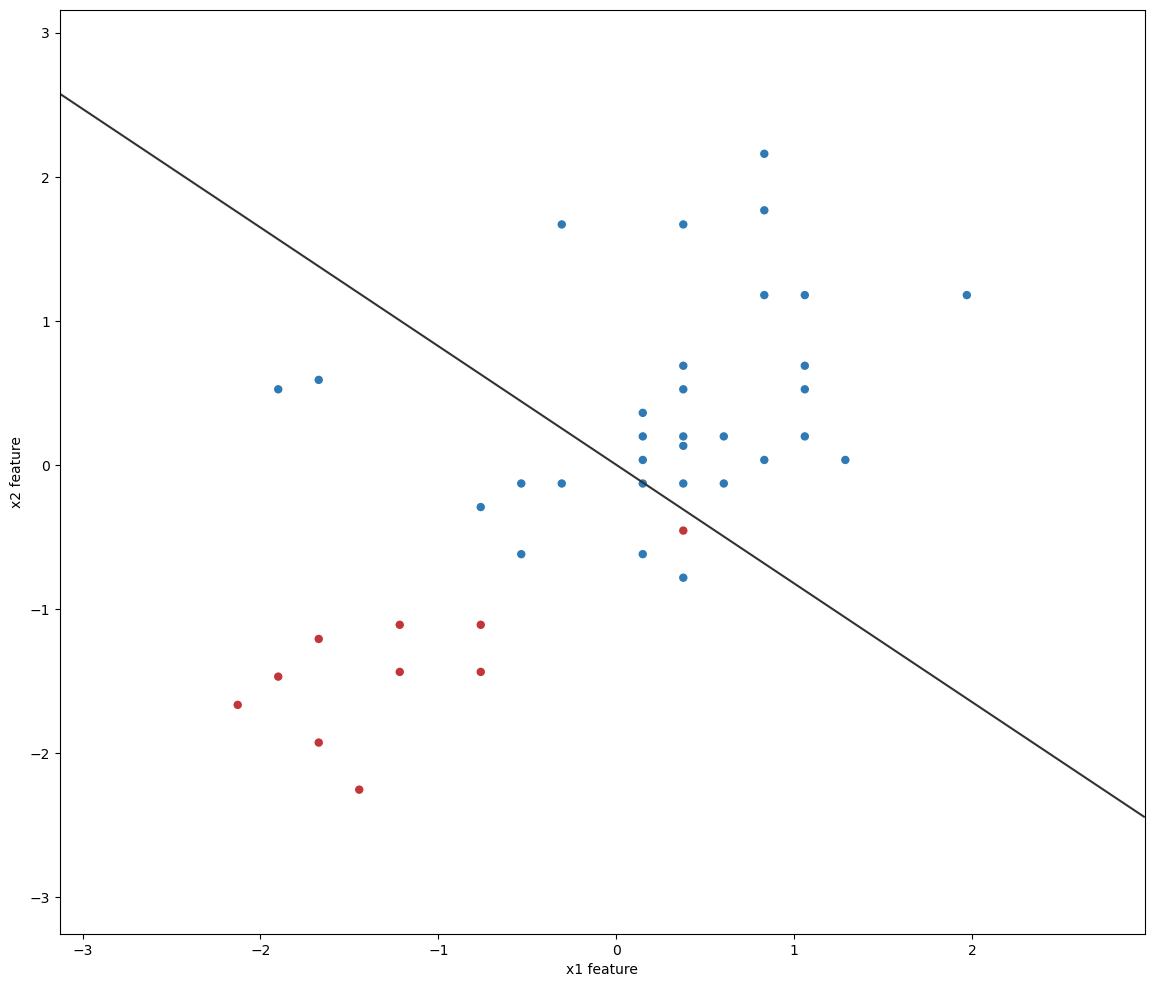

In [11]:
solver = LogisticRegressionClass(data= X, target= y, learning_rate = 1e-5, 
                                 epsilon = 1e-5, max_iterations= 100000, fit_intercept = False)
solver.fit()
solver.plot()
solver.plot3D()
solver.scatterPlt()

Testing metrics


,Values
Metrics,
Accuracy,0.694737
Error rate,0.305263
Sensitivity/Recall/True Positive Rate,0.608108
False Negative Rate,0.391892
Specificity/True Negative Rate,1.000000
F1 score,0.756303
Positive Predictive Value (PPV) or Precision,1.000000


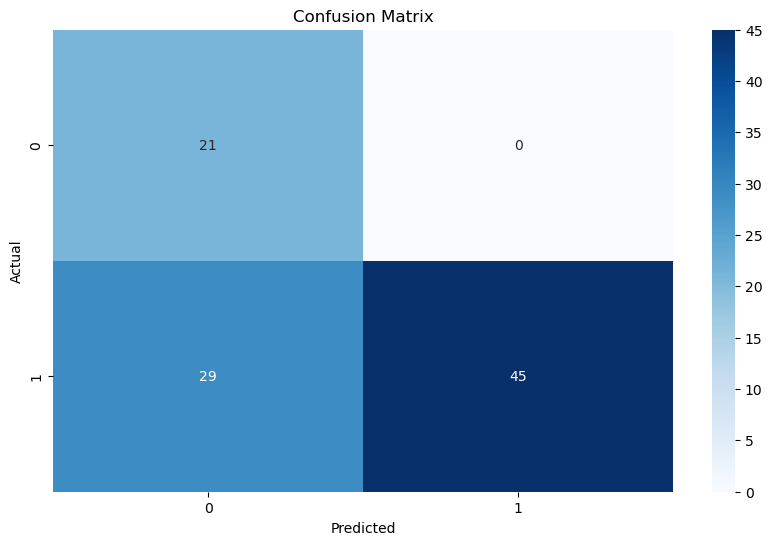

In [12]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = "test")

  7%|▋         | 7155/99999 [00:00<00:07, 12620.10it/s]


Done
Gradient descent used
[0.49737403 0.62089509] 

Training metrics


,Values
Metrics,
Accuracy,0.795455
Error rate,0.204545
Sensitivity/Recall/True Positive Rate,0.742857
False Negative Rate,0.257143
Specificity/True Negative Rate,1.000000
F1 score,0.852459
Positive Predictive Value (PPV) or Precision,1.000000


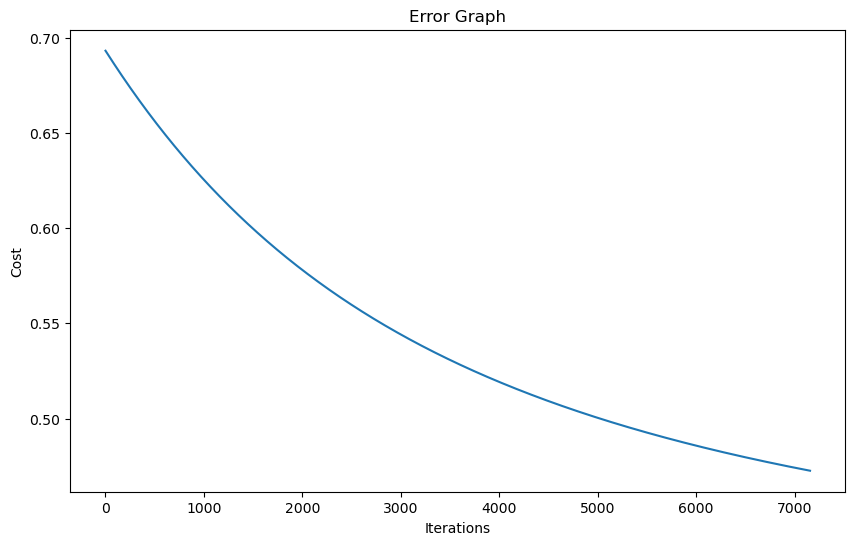

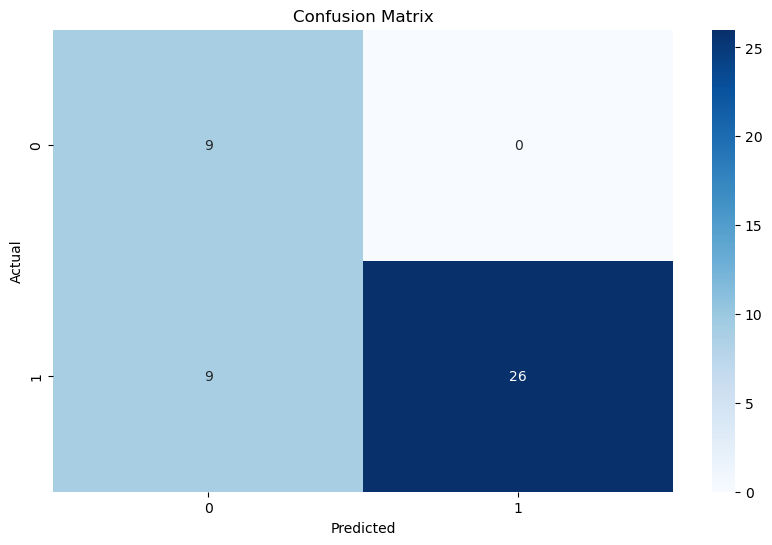

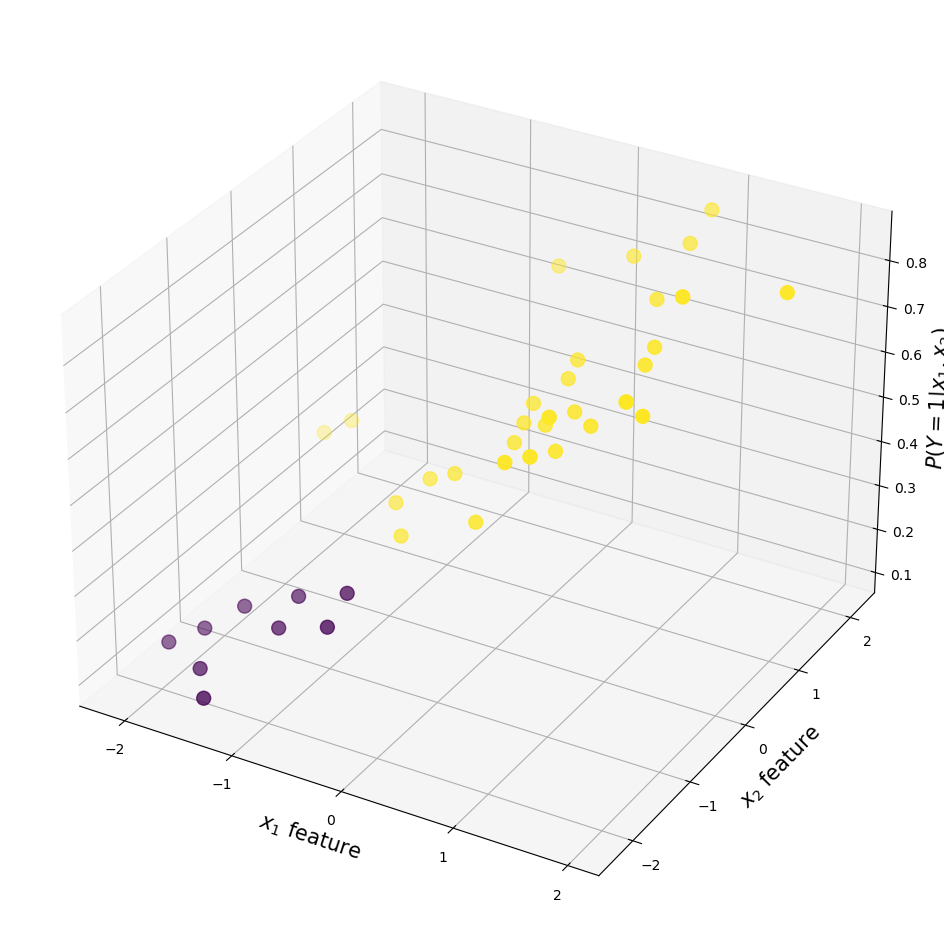

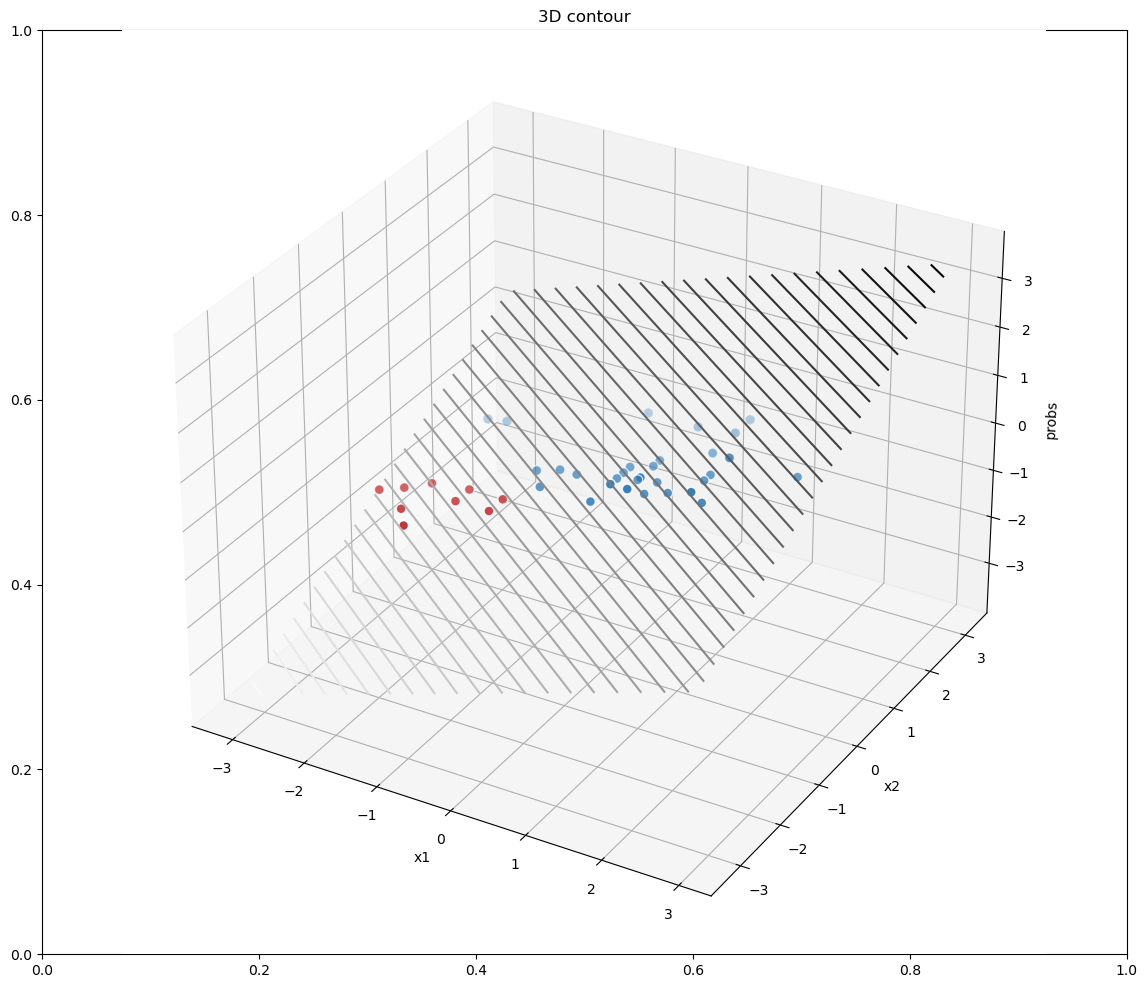

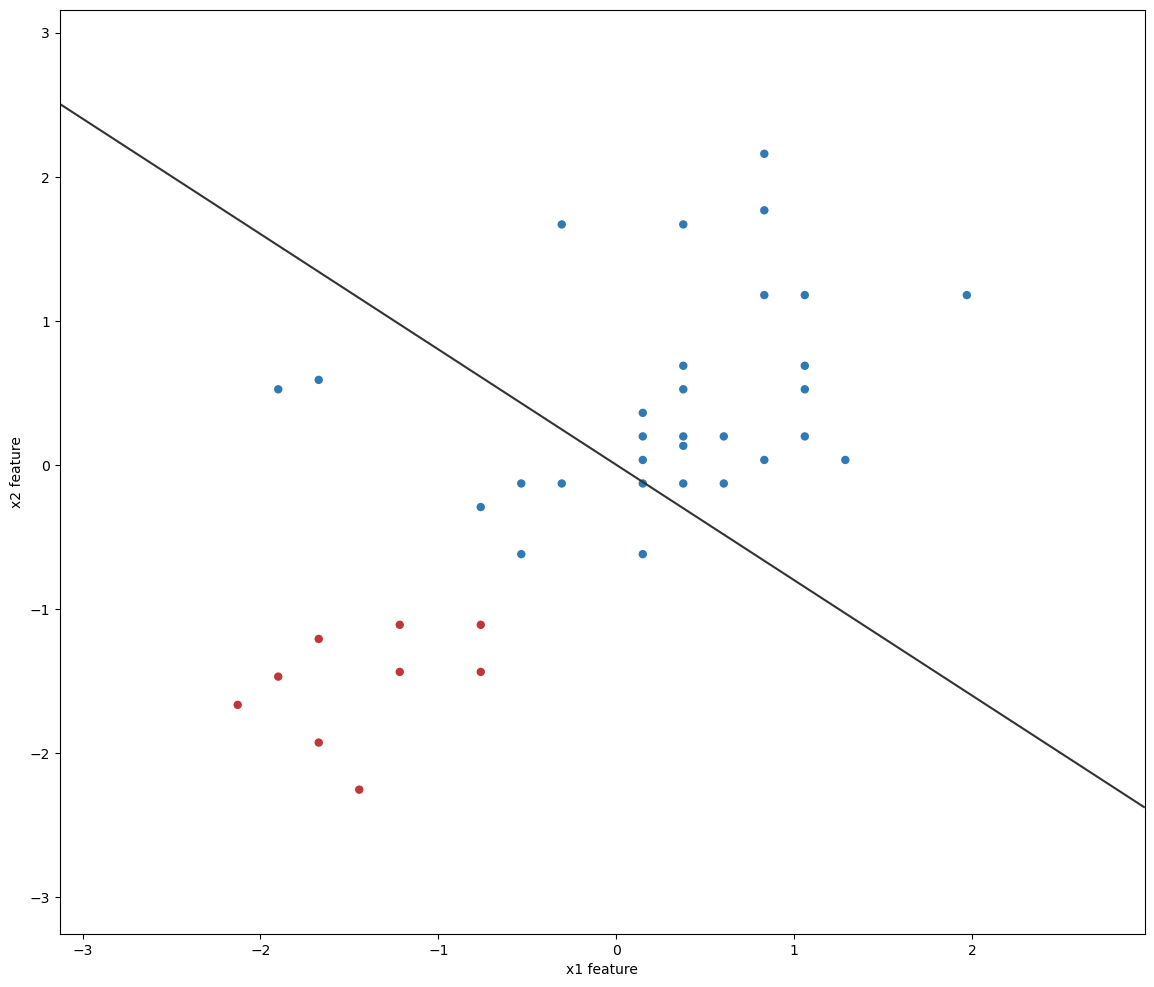

In [13]:
solver = LogisticRegressionClass(data= X, target= y, learning_rate = 1e-5, 
                                 epsilon = 1e-5, max_iterations= 100000, remove_index = [1, 39], fit_intercept = False)
solver.fit()
solver.plot()
solver.plot3D()
solver.scatterPlt()

Testing metrics


,Values
Metrics,
Accuracy,0.694737
Error rate,0.305263
Sensitivity/Recall/True Positive Rate,0.608108
False Negative Rate,0.391892
Specificity/True Negative Rate,1.000000
F1 score,0.756303
Positive Predictive Value (PPV) or Precision,1.000000


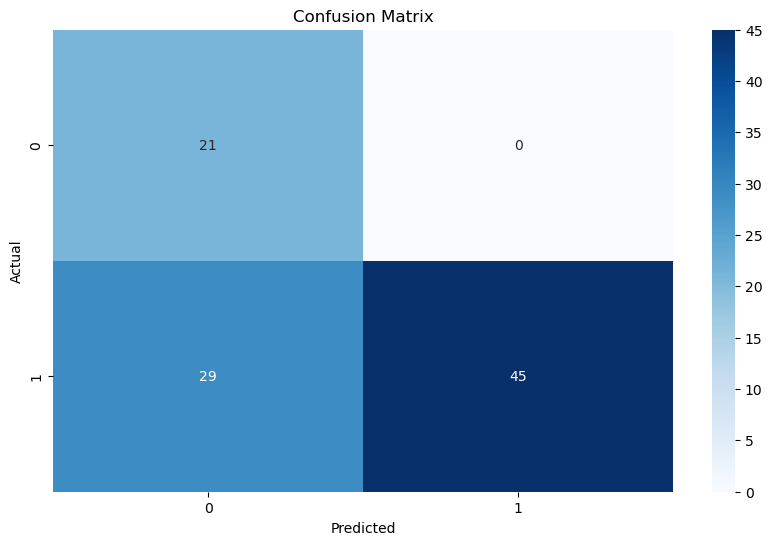

In [14]:
solver.evaluation_metrics(X = X_test, y = y_test, mode = "test")